In [9]:
import numpy as np   
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score



# Data processing 

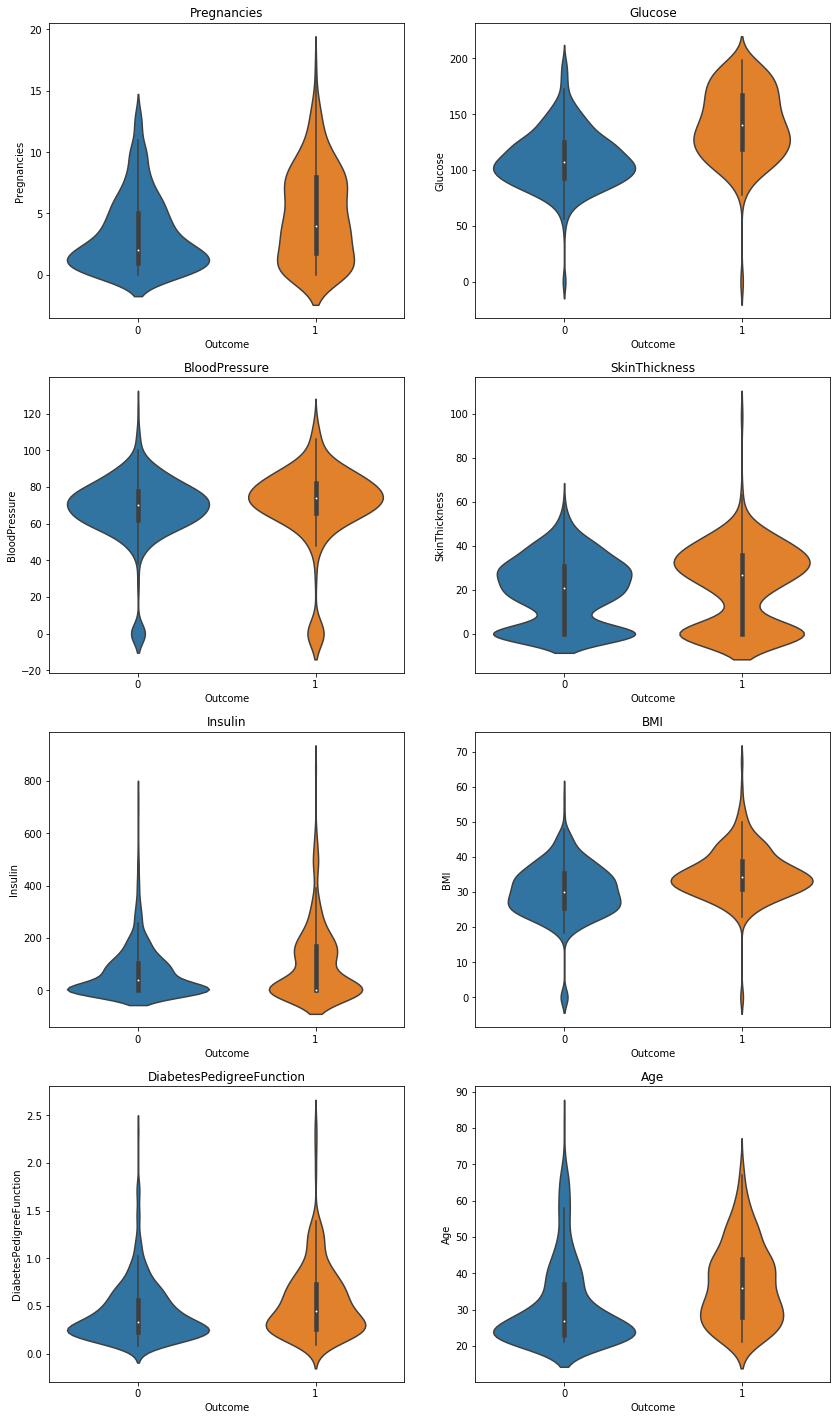

In [10]:
data = pd.read_csv("diabetes.csv")
attributes = data.drop("Outcome",axis=1).columns


In [33]:
def violin_plot(nrow=4,ncol=2): 
    """
    funtion to plot violin plot for all attributes
    
    input : optional input for number of column and rows for subplot by default value are 2,4 respectively
    
    output : violin plot for all attribute of dataframe 
    
    return : none
    """
    fig = plt.figure(figsize=(14,25))
    fig.tight_layout(pad=3.0)
    nrow,ncol,index=4,2,1    
    for attribute in attributes:
        plt.subplot(nrow, ncol, index)
        plt.title(attribute)
        sns.violinplot(x="Outcome", y=attribute, data=data)
        index+=1
    plt.show()
        
def plot_auc(fpr,tpr,auc_model):
    """This function pots the ROC curve with help of False positive rate
    and True positive rate and auc object"""
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_model))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
 

# calculation of median for each attribute for both possible outcome  
def median_target(attribute):
    """
    This function replaces the Nan of given attribute with 
    median when grouped by Outcome into the global variable 
    data("dataframe")
    
    input : attribute 
    
    output : column of that attibute is modified 
    
    return : none
    """
    temp = data[data[attribute].notnull()]# assigning non null value to temp 
    temp = temp[[attribute, 'Outcome']].groupby(['Outcome'])[[attribute]].mean().reset_index() #calculate mean for a attribute with either 0 or 1 outcome 
    mean_op_0=temp[attribute][0]
    mean_op_1=temp[attribute][1]
    data.loc[(data['Outcome'] == 0 ) & (data[attribute].isnull()), attribute] = mean_op_0 #assigning mean to null values 
    data.loc[(data['Outcome'] == 1 ) & (data[attribute].isnull()), attribute] = mean_op_1

def median_target_all():
    # calling meadian_target for each attribute
    for attribute in attributes:
            median_target(attribute) 
        
def outliers_removal():
    """
    This function removes outlier of the global variable data(dataframe)
    using IQR method 
    """
    #loop for replacing outlier of all attribute with Nan value 
    for attribute in attributes:
        q1 = data[attribute].quantile(0.25)
        q3 = data[attribute].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        data.loc[(data[attribute] < fence_low) | (data[attribute] > fence_high),attribute]=np.nan

        
def z_score(df):
    """Function for apply z score standardization
       Input: dataframe to be standardized
       output :standardized dataframe 
    """
    df_std = df.copy()
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()     
    return df_std



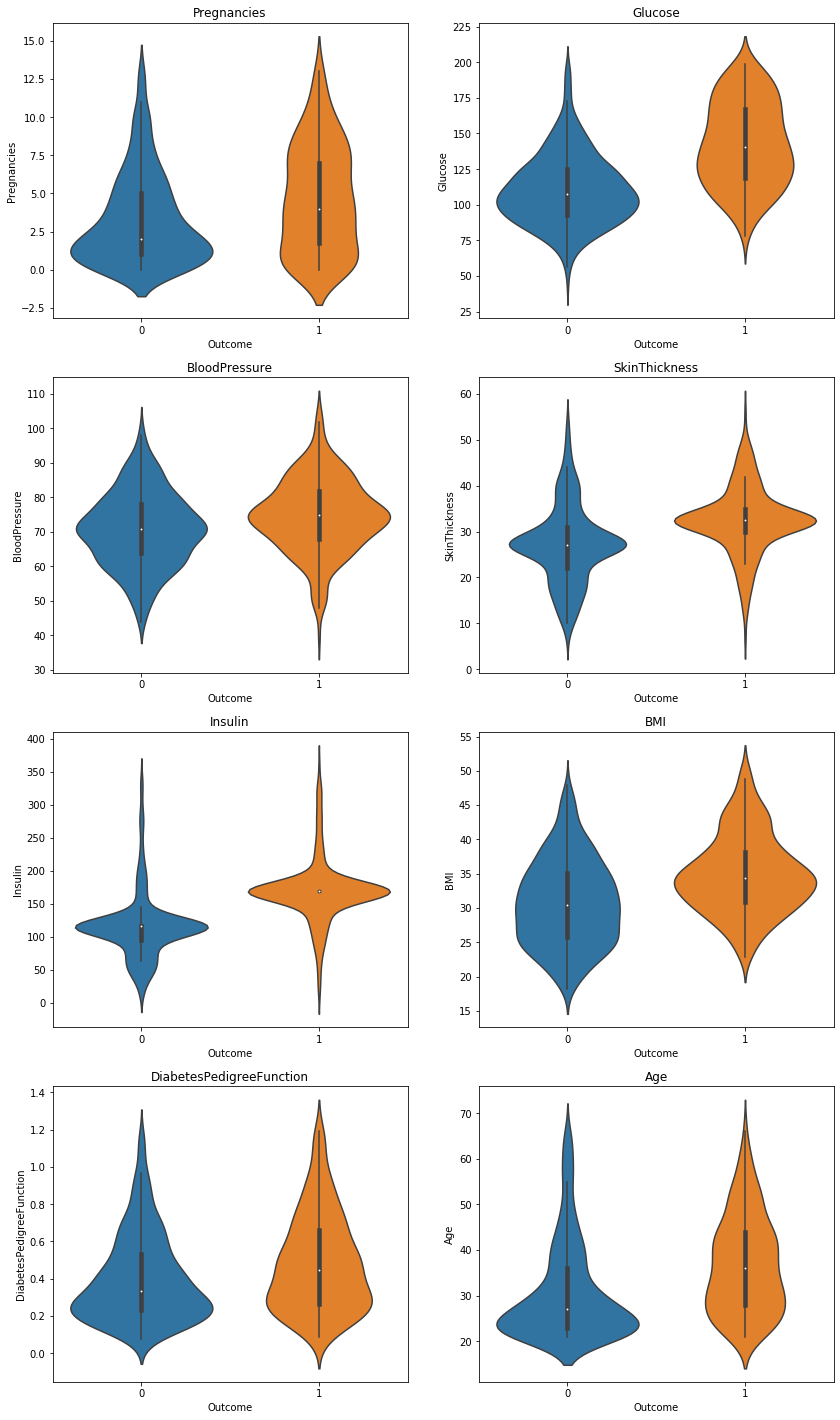

In [34]:
violin_plot()

In [35]:
# replacing missing value with nan value
data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]]=data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.nan)

median_target_all()

outliers_removal()
median_target_all()


In [36]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


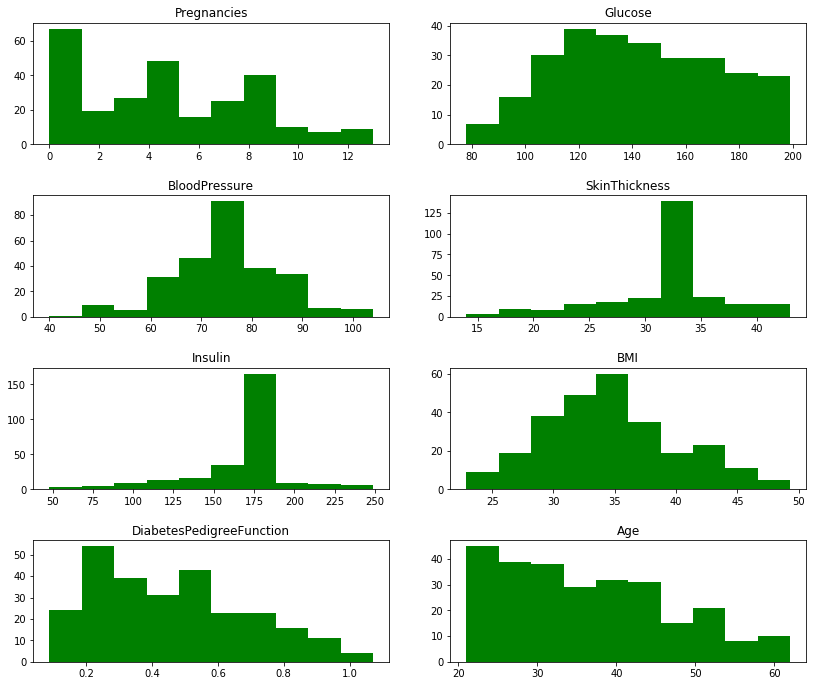

In [37]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
fig.tight_layout(pad=3.0)
k=0
for i in range(0,4):
    for j in range(0,2):
        ax[i,j].set_title(attributes[k])
        ax[i,j].hist(data[attributes[k]][data.Outcome==1],color="green")
        k+=1

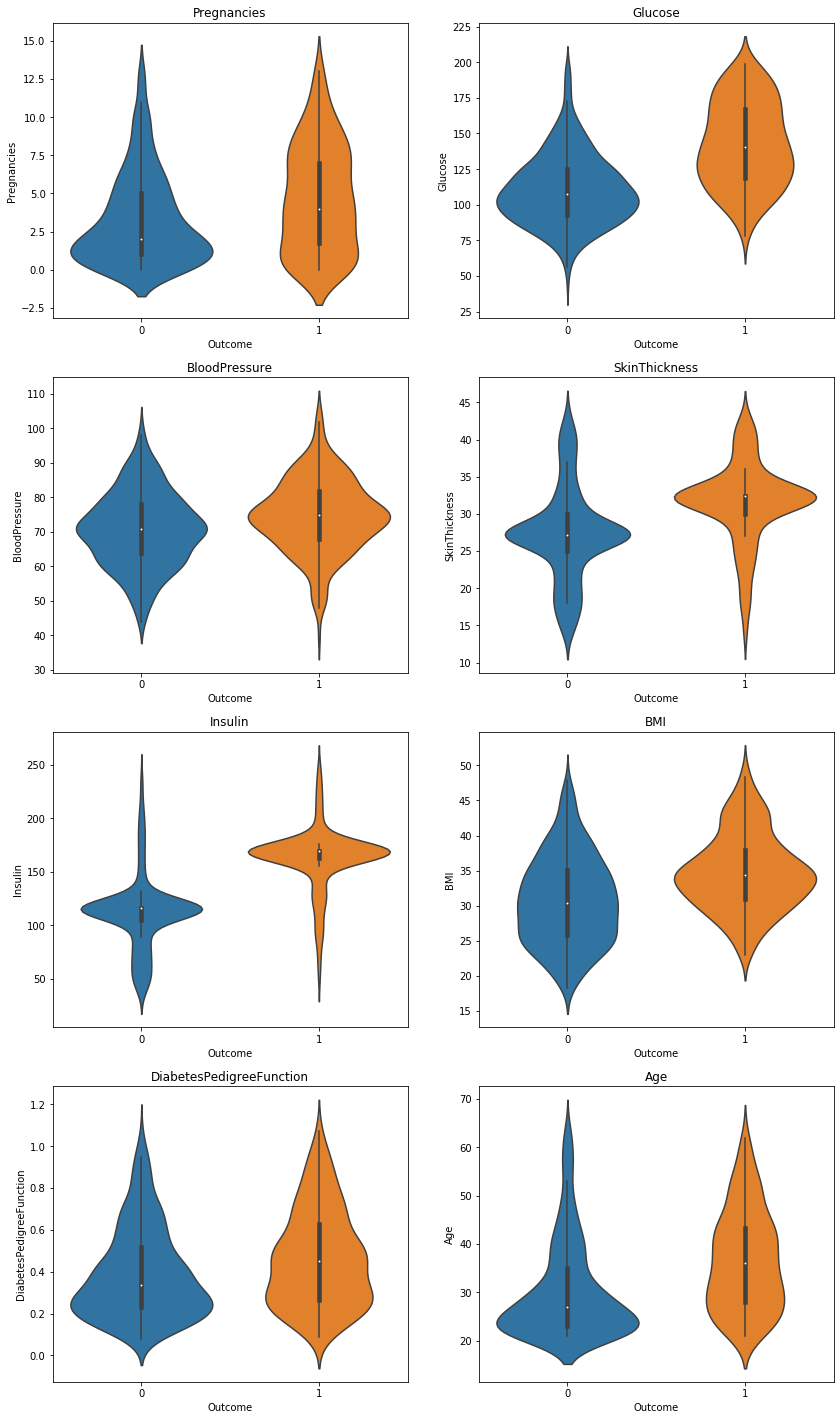

In [38]:
violin_plot()

In [39]:
# standardization of dataset
data_std=z_score(data)

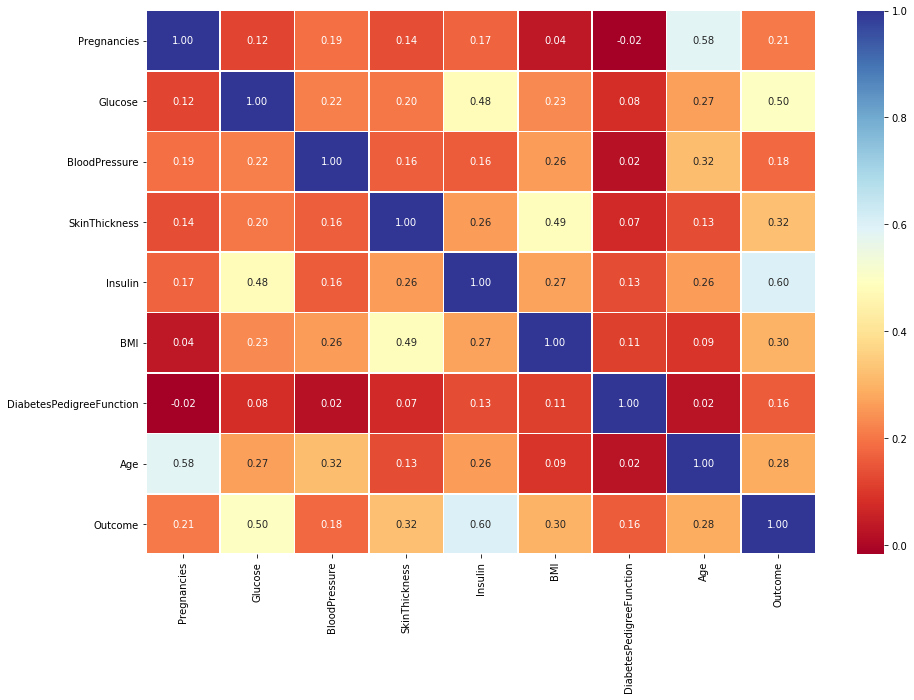

In [40]:
# It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data_std.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="RdYlBu")

###### Distribution of data set 

In [41]:
y = data["Outcome"]
X=data_std.drop("Outcome",axis=1)
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)


# Models 

In [18]:
"""from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
list_of_algo=[SVC(),AdaBoostClassifier(), 
              RandomForestClassifier(),
              LogisticRegression(),KNeighborsClassifier()]
name_of_algo=["SVM","AdaBoostClassifier", 
              "RandomForestClassifier",
              "LogisticRegression","KNeighborsClassifier"]
for i,algorithm in enumerate(list_of_algo):
    steps = [('pca', PCA(n_components=6)), ('m', algorithm)]
    model = Pipeline(steps=steps)
# evaluate model
    model_score = cross_val_score(model, X, y, scoring='accuracy', n_jobs=-1, error_score='raise')
    print("*"*120)
    print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))"""

************************************************************************************************************************
Accuracy of SVM : 85.16000339529751 
************************************************************************************************************************
Accuracy of AdaBoostClassifier : 81.1272387742976 
************************************************************************************************************************
Accuracy of RandomForestClassifier : 82.42678889737712 
************************************************************************************************************************
Accuracy of LogisticRegression : 79.17154740684154 
************************************************************************************************************************
Accuracy of KNeighborsClassifier : 82.94457176810118 


************************************************************************************************************************
Accuracy of SVM : 88.01910507792863 
Precision of SVM : 89.79591836734694 
Recall of SVM : 80.0 


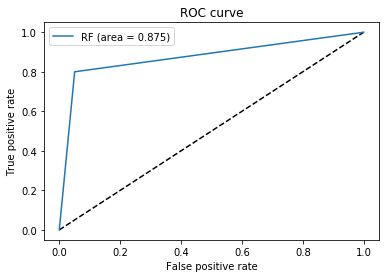

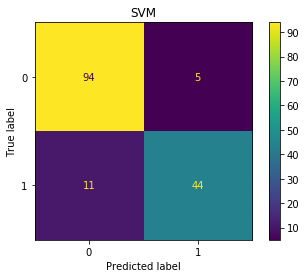

************************************************************************************************************************
Accuracy of AdaBoostClassifier : 90.62342885872299 
Precision of AdaBoostClassifier : 87.03703703703704 
Recall of AdaBoostClassifier : 85.45454545454545 


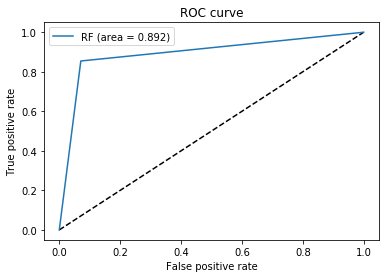

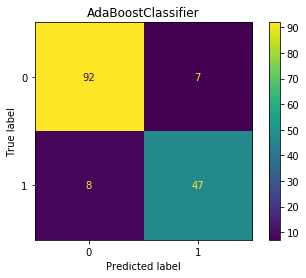

************************************************************************************************************************
Accuracy of RandomForestClassifier : 90.23127199597789 
Precision of RandomForestClassifier : 93.75 
Recall of RandomForestClassifier : 81.81818181818183 


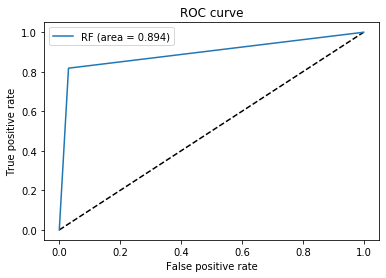

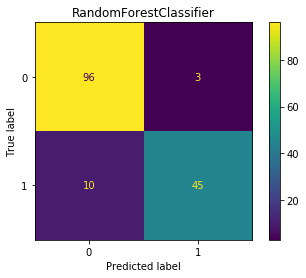

************************************************************************************************************************
Accuracy of LogisticRegression : 87.09904474610359 
Precision of LogisticRegression : 85.1063829787234 
Recall of LogisticRegression : 72.72727272727273 


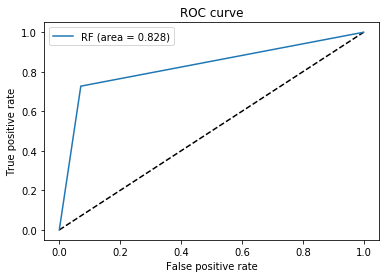

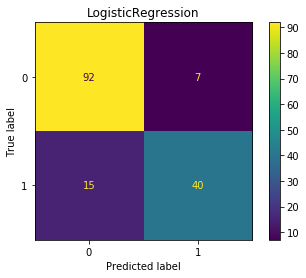

************************************************************************************************************************
Accuracy of KNeighborsClassifier : 88.15485168426346 
Precision of KNeighborsClassifier : 93.33333333333333 
Recall of KNeighborsClassifier : 76.36363636363637 


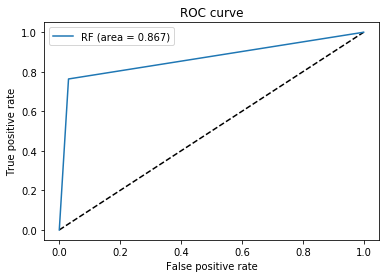

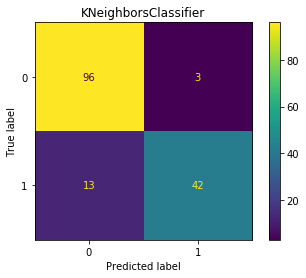

In [43]:
from sklearn.metrics import roc_curve,auc
list_of_algo=[SVC(),AdaBoostClassifier(), 
              RandomForestClassifier(),
              LogisticRegression(),KNeighborsClassifier()]
name_of_algo=["SVM","AdaBoostClassifier", 
              "RandomForestClassifier",
              "LogisticRegression","KNeighborsClassifier"]
for i,algorithm in enumerate(list_of_algo):
    model=algorithm
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    model_score=cross_val_score(model,X,y,cv=15)
    
    y_pred_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_model = auc(fpr, tpr)
    print("*"*120)
    print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))
    print('Precision of {} : {} '.format(name_of_algo[i],(precision_score(y_test,y_pred)*100)))
    print('Recall of {} : {} '.format(name_of_algo[i],(recall_score(y_test,y_pred)*100)))
    plot_auc(fpr,tpr,auc_model)
    plot_confusion_matrix(model, X_test, y_test,values_format="d")
    plt.title(name_of_algo[i])
    plt.show()    

In [27]:
from sklearn.model_selection import GridSearchCV
print(RandomForestClassifier())
n_estimators = [100, 200, 250, 300, 350]
max_depth = [1, 3, 4, 5, 8, 10]
min_samples_split = [10, 15, 20, 25, 30, 100]
min_samples_leaf = [1, 2, 4, 5, 7] 
max_features = ['auto', 'sqrt']
criterion='gini'
bootstrap = [True, False]
rfr=RandomForestClassifier()
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,criterion=criterion
              max_features = max_features,  min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,bootstrap = bootstrap)

gridF = GridSearchCV(rfr, hyperF,scoring='accuracy', cv = 5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

"from sklearn.model_selection import GridSearchCV\nprint(RandomForestClassifier())\nn_estimators = [100, 200, 250, 300, 350]\nmax_depth = [1, 3, 4, 5, 8, 10]\nmin_samples_split = [10, 15, 20, 25, 30, 100]\nmin_samples_leaf = [1, 2, 4, 5, 7] \nmax_features = ['auto', 'sqrt']\nbootstrap = [True, False]\nrfr=RandomForestClassifier()\nhyperF = dict(n_estimators = n_estimators, max_depth = max_depth,\n              max_features = max_features,  min_samples_split = min_samples_split, \n              min_samples_leaf = min_samples_leaf,bootstrap = bootstrap)\n\ngridF = GridSearchCV(rfr, hyperF,scoring='accuracy', cv = 5, verbose = 1, \n                      n_jobs = -1)\nbestF = gridF.fit(X_train, y_train)"

In [44]:
forestOpt = RandomForestClassifier(n_estimators = 100,criterion='gini')

modelOpt = forestOpt.fit(X_train, y_train)
model_score=cross_val_score(forestOpt,X,y,cv=4)
y_pred = modelOpt.predict(X_test)
print(modelOpt.score(X_test,y_test))
print("score",model_score.mean())

0.922077922077922
score 0.8971354166666666


Epoch 1/200
77/77 [==============================] - 0s 894us/step - loss: 0.6111 - accuracy: 0.6840
Epoch 2/200
77/77 [==============================] - 0s 1ms/step - loss: 0.4554 - accuracy: 0.7899
Epoch 3/200
77/77 [==============================] - 0s 1ms/step - loss: 0.4003 - accuracy: 0.8127
Epoch 4/200
77/77 [==============================] - 0s 1ms/step - loss: 0.3692 - accuracy: 0.8518
Epoch 5/200
77/77 [==============================] - 0s 1ms/step - loss: 0.3486 - accuracy: 0.8599
Epoch 6/200
77/77 [==============================] - 0s 1ms/step - loss: 0.3329 - accuracy: 0.8681
Epoch 7/200
77/77 [==============================] - 0s 1ms/step - loss: 0.3209 - accuracy: 0.8844
Epoch 8/200
77/77 [==============================] - 0s 1ms/step - loss: 0.3110 - accuracy: 0.8876
Epoch 9/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3032 - accuracy: 0.8893
Epoch 10/200
77/77 [==============================] - 0s 2ms/step - loss: 0.2967 - accuracy: 0.8844
Epoch 1

Epoch 83/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.9723
Epoch 84/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9788
Epoch 85/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.9788
Epoch 86/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0744 - accuracy: 0.9772
Epoch 87/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0725 - accuracy: 0.9772
Epoch 88/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.9772
Epoch 89/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.9772
Epoch 90/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0688 - accuracy: 0.9739
Epoch 91/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0747 - accuracy: 0.9788
Epoch 92/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0998 - accuracy: 0.9609


77/77 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9707
Epoch 164/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.9772
Epoch 165/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9756
Epoch 166/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0602 - accuracy: 0.9805
Epoch 167/200
77/77 [==============================] - 0s 2ms/step - loss: 0.1303 - accuracy: 0.9577
Epoch 168/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0585 - accuracy: 0.9739
Epoch 169/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9853
Epoch 170/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9886
Epoch 171/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9902
Epoch 172/200
77/77 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9886
Epoc

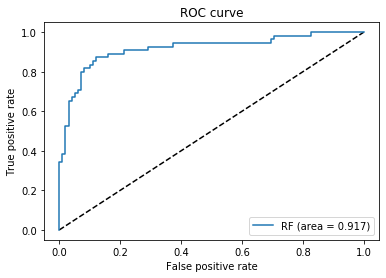

In [49]:

##Build an model(Neural model )
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fit=model.fit(X_train, y_train, epochs=200, batch_size=8)
_, nn_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_nn = auc(fpr, tpr)
plot_auc(fpr,tpr,auc_nn)



In [47]:
print(nn_acc)

0.8116883039474487
